In [2]:
# import the necessary packages
import torch
import os

# define path to the original dataset and base path to the dataset
# splits
BASE_PATH = "crops_greyscale"

TRAIN = os.path.join(BASE_PATH, "train")
VAL = os.path.join(BASE_PATH, "test")

# specify training hyperparameters
FEATURE_EXTRACTION_BATCH_SIZE = 8
EPOCHS = 10
LR = 0.005

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torch.utils.data import DataLoader
from torchvision import datasets
import os

def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
    # create a dataset and use it to create a data loader
    ds = datasets.ImageFolder(root=rootDir,
        transform=transforms)
    loader = DataLoader(ds, batch_size=batchSize,
        shuffle=shuffle,
        num_workers=os.cpu_count(),
        pin_memory=True if DEVICE == "cuda" else False)
    # return a tuple of  the dataset and the data loader
    return (ds, loader)

from torchvision import transforms

# define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
valTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [3]:
(trainDS, trainLoader) = get_dataloader(TRAIN,
    transforms=trainTansform, batchSize=FEATURE_EXTRACTION_BATCH_SIZE)
(valDS, valLoader) = get_dataloader(VAL,
    transforms=valTransform, batchSize=FEATURE_EXTRACTION_BATCH_SIZE,
    shuffle=False)

In [4]:
from torch import nn
model = torch.load('results/experiment2/nn_pretrained/nn27')
numFeatures = model.fc.in_features
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(numFeatures, len(trainDS.classes))
model = model.to(DEVICE)

In [38]:
from torch import nn
model = torch.load('results/experiment2/nn_pretrained/nn27')
numFeatures = model.fc.in_features

# loop over the modules of the model and set the parameters of
# batch normalization modules as not trainable
for module, param in zip(model.modules(), model.parameters()):
    if isinstance(module, nn.BatchNorm2d):
        param.requires_grad = False
# define the network head and attach it to the model
headModel = nn.Sequential(
    nn.Linear(numFeatures, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(trainDS.classes))
)
model.fc = headModel
# append a new classification top to our feature extractor and pop it
# on to the current device
model = model.to(DEVICE)

In [5]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // FEATURE_EXTRACTION_BATCH_SIZE
valSteps = len(valDS) // FEATURE_EXTRACTION_BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
    "val_acc": []}

[INFO] training the network...


 10%|████████▎                                                                          | 1/10 [00:31<04:47, 31.91s/it]

[INFO] EPOCH: 1/10
Train loss: 0.540951, Train accuracy: 0.8226
Val loss: 2.156997, Val accuracy: 0.5833


 20%|████████████████▌                                                                  | 2/10 [01:07<04:33, 34.24s/it]

[INFO] EPOCH: 2/10
Train loss: 0.590512, Train accuracy: 0.8065
Val loss: 2.381982, Val accuracy: 0.5000


 30%|████████████████████████▉                                                          | 3/10 [01:44<04:08, 35.44s/it]

[INFO] EPOCH: 3/10
Train loss: 0.474826, Train accuracy: 0.8548
Val loss: 2.802605, Val accuracy: 0.5833


 40%|█████████████████████████████████▏                                                 | 4/10 [02:20<03:32, 35.49s/it]

[INFO] EPOCH: 4/10
Train loss: 0.537804, Train accuracy: 0.8387
Val loss: 0.875612, Val accuracy: 0.8333


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:55<02:57, 35.59s/it]

[INFO] EPOCH: 5/10
Train loss: 1.164045, Train accuracy: 0.6452
Val loss: 1.744163, Val accuracy: 0.5833


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:31<02:22, 35.56s/it]

[INFO] EPOCH: 6/10
Train loss: 0.330959, Train accuracy: 0.9032
Val loss: 1.726263, Val accuracy: 0.6667


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:07<01:46, 35.64s/it]

[INFO] EPOCH: 7/10
Train loss: 0.391767, Train accuracy: 0.8871
Val loss: 1.764069, Val accuracy: 0.5833


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:42<01:11, 35.63s/it]

[INFO] EPOCH: 8/10
Train loss: 0.472211, Train accuracy: 0.8226
Val loss: 3.078198, Val accuracy: 0.5000


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:17<00:35, 35.38s/it]

[INFO] EPOCH: 9/10
Train loss: 0.349657, Train accuracy: 0.9194
Val loss: 5.717116, Val accuracy: 0.4167


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:53<00:00, 35.39s/it]

[INFO] EPOCH: 10/10
Train loss: 0.619426, Train accuracy: 0.7903
Val loss: 2.843130, Val accuracy: 0.5833
[INFO] total time taken to train the model: 353.90s


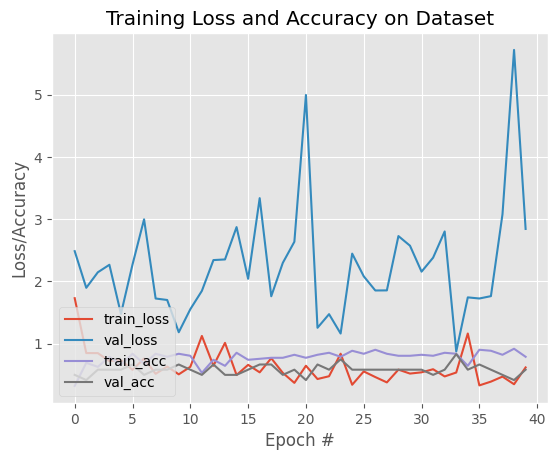

In [21]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)
        # calculate the gradients
        loss.backward()
        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
        
        
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [35]:
# serialize the model to disk
torch.save(model, 'results/experiment2/nn_transfer_learned/nn36')

### Testing

In [36]:
import torch
model = torch.load('results/experiment2/nn_transfer_learned/nn17')
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = 'cpu'
model = model.to(DEVICE)

In [37]:
model = model.to('cpu')

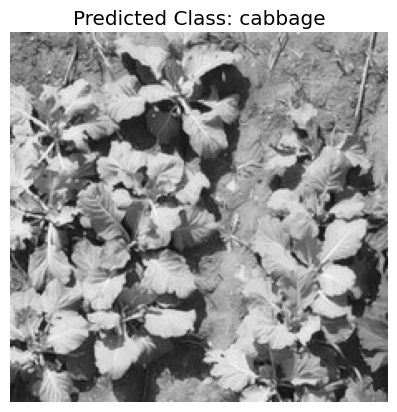

In [38]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
DEVICE = 'cpu'
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('crops/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

classes = train_dataset.classes

# Визуализация предсказаний
sample_image = Image.open('./crops_greyscale/test/cabbage/Screenshot_1.jpg')
sample_image_tensor = transform(sample_image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    model.eval()
    output = model(sample_image_tensor)
    _, predicted_index = torch.max(output.data, 1)
    prob = torch.nn.functional.softmax(output, dim=1)
    
    if prob.max().item() > 0.7:
        predicted_class = classes[predicted_index.item()]
    else:
        predicted_class = 'None'

plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

In [32]:
# Script 
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets
from torch.nn.functional import softmax
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def crop_predict_image(path_image: str, model: torchvision.models.resnet.ResNet):
    '''
    Функция принимает на вход путь к изображению, разрезает его,
    каждый фрагмент отправляет в модель.
    Выходное значение - список тензоров с вероятноястями.
    '''
        
    device = torch.device("cpu")
        
    image = Image.open(path_image)
    width, height = image.size
    
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    train_dataset = datasets.ImageFolder('crops/train', transform=transform)
    classes = train_dataset.classes
    
    # Список из списков с тензорами вероятностей классов
    predicted_output = [[] for lst in range(0, 19)]
    
    # Настройки для отрисовывания
    colors = ['red', 'blue', 'yellow', 'green', 'orange', 'brown', 'white', 'black']
    
    classes_colors = dict(zip(range(0, 100), zip(classes, colors)))
    
    draw = ImageDraw.Draw(image)
    
    upper = 0
    lower = round(height * 0.1)
    
    row = -1
    
    for h in range(0, 19):
        row += 1
        left = 0
        right = round(width * 0.1)
        
        for w in range(0, 19):
            cropped_image = image.crop((left, upper, right, lower))
            transfromed_image = transform(cropped_image).unsqueeze(0).to(device)
            
            predicted = softmax(model(transfromed_image), -1)
            
            predicted_output[row].append(predicted)
            
            if float(torch.max(predicted)) > 0.98:
                index = int(torch.argmax(predicted))
                
                draw.line((left, upper, right, upper), fill=classes_colors[index][1], width=10)
                draw.line((right, upper, right, lower), fill=classes_colors[index][1], width=10)
                draw.line((left, lower, right, lower), fill=classes_colors[index][1], width=10)
                draw.line((left, lower, left, upper), fill=classes_colors[index][1], width=10)
            
            left += round(width * 0.1)
            right += round(width * 0.1)
            
        upper += round(height * 0.1)
        lower += round(height * 0.1)
    
    text = ''
    for i in classes_colors:
        text = text + classes_colors[i][0] + ' - ' + classes_colors[i][1] + ' \n'
    
    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.title(text)
    plt.show()
    
    return image, predicted_output, classes

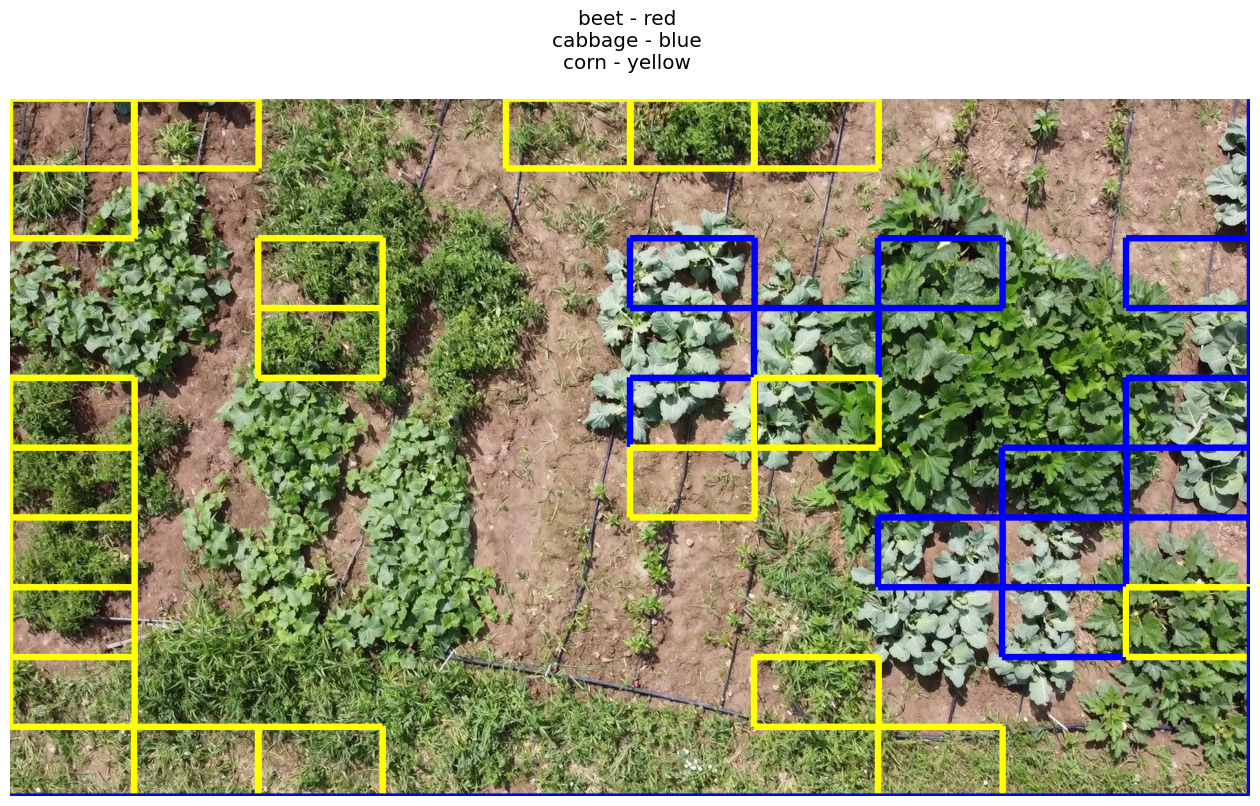

In [39]:
image, predicted_output, classes = crop_predict_image('./test_multiple/frame6059.jpg', model)

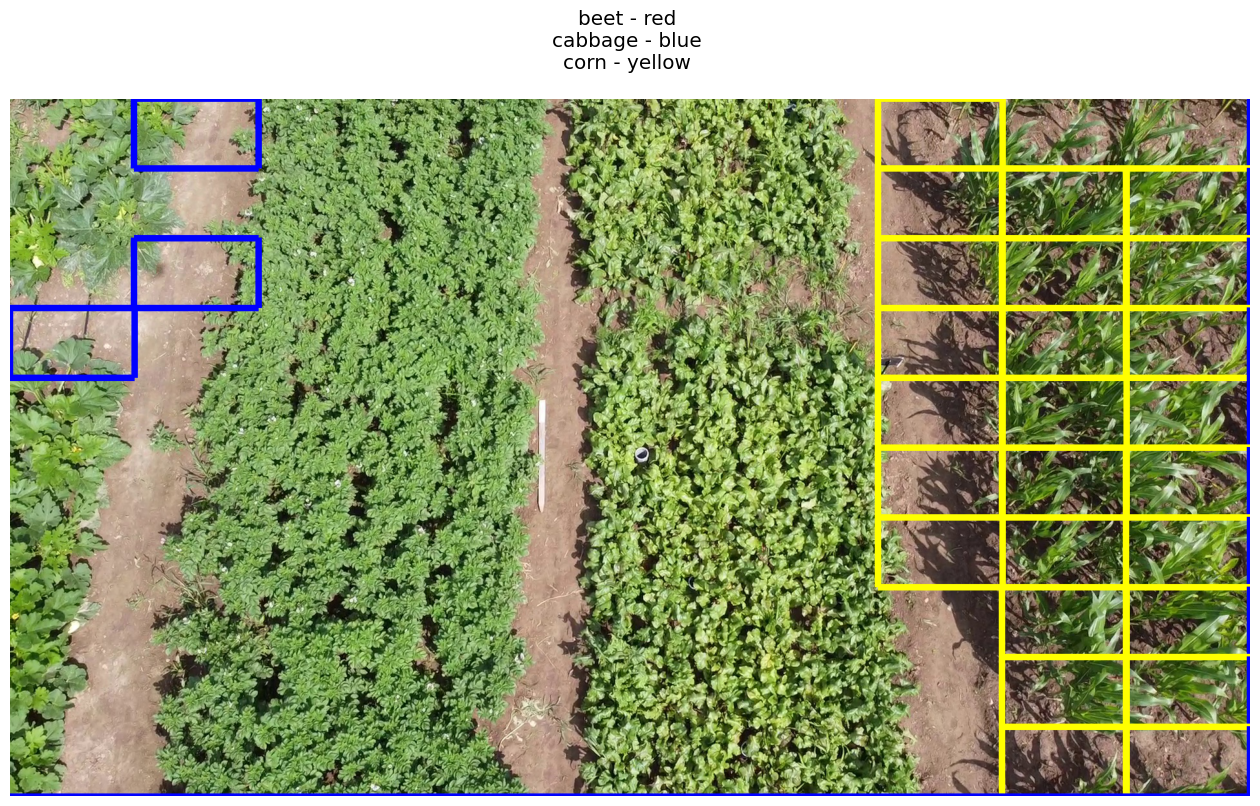

In [40]:
image, predicted_output, classes = crop_predict_image('./test_multiple/frame2300.jpg', model)

### Testing on greyscale images

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  